# A GAN to generate cows and horses images

This is just for the GPU not to be disabled by google

In [ ]:
!sudo apt-get remove libtcmalloc-minimal4
!sudo apt-get update
!sudo apt-get install libtcmalloc-minimal4

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

Setting Variables and Hyperparameters

In [ ]:
path = "/content/drive/MyDrive/Newdata/Train"

noise_dim = 100
num_examples_to_generate = 4

BUFFER_SIZE = 82
BATCH_SIZE = 10


global g_loss
global d_loss
g_loss=[]
d_loss=[]



1.   Importing the dataset from the path with shuffling and resizing the images to 70*70px 
2.   transforming images to array lists



In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
path,
  seed=123,
  validation_split=0,
  image_size=(70, 70),
  color_mode="rgb",
  shuffle=True,
  batch_size=1) #batch size is set to one as we will reorganize the dataset to tensorflow slices later


train_images_array = []
for images, _ in train_dataset:
    for i in range(len(images)):
      train_images_array.append(images[i])

Found 82 files belonging to 2 classes.


Transforming images to numpy arrays then Normalize the images to [-1, 1]

In [ ]:
train_images = np.array(train_images_array)
train_images = train_images.reshape(train_images.shape[0],70,70,3).astype('float32')
train_images = (train_images - 127.5) / 127.5  

here we batch and shuffle the data to be fed to the training loop later

In [ ]:
dataset_ = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

The generator model takes a random vector, dense it to 7 * 7 *256 then feed it the next layer.
At the end we will end up with 70 * 70 *3 images

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (20, 20), strides=(5, 5), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 70, 70, 3)
    return model

generator = make_generator_model()

generator.summary()

(None, 70, 70, 3)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_9 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None,

Check the generator by feeding it with a random vector, training is set to false as this is just for showcasing 

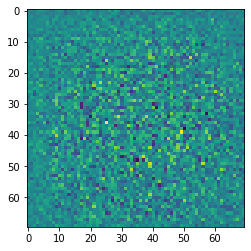

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

The discriminator model is chosen to be a simple model as we dont want it to overperform the generator. 

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (10, 10), strides=(2, 2), padding='same', input_shape=[70, 70, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[70, 70, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=[70, 70, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 35, 35, 64)        19264     
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 35, 35, 64)        0         
                                                                 
 dropout_9 (Dropout)         (None, 35, 35, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       204928    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 18, 18, 128)       0         
                                                                 
 dropout_10 (Dropout)        (None, 18, 18, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 9, 9, 256)        

Check the discriminator by feeding it with the last generated image

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00045495]], shape=(1, 1), dtype=float32)


As the loss function: Binary Cross entropy is proven to be the best in classifier problems thus it is chosen 
As the optimizer: Adam with epsilon of about 1e-4 is choosed.
For it (1e-2) diverged and gave loss of about (1e6), For (1e-7) weight update was very slow so (1e-4) is chosen.

Discriminator loss depends on both the real and the generated images and it takes the cross entropy of both to get the total loss 

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

seed is fixed here so that we can reuse it over time in the image display allong the training and see the progress as GIF

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

At each epoch, we want to see the progress so we use this to plot it and produce a GIF

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow((predictions[i] + 1) / 2)

      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

  plt.show()

Takes a batch of images at once and train it by getting the generator and discriminator loss then applying the optimizer and updates the wieghts

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss 

Here is the main loop, where we call the train step function for a batch of images get the losses to plot them. 
Repeat this n number of epochs while plotting GIF at each epoch 

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
  
    for image_batch in dataset:
      [g,d] = train_step(image_batch)
      print("g_loss: ",g)
      print("d_loss: ",d)
      g_loss.append(g)
      d_loss.append(d)
      
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                           seed)


In [ ]:
train(dataset_, 2000)

check that the loss list is appending correctly

In [ ]:
len(g_loss)

Plot the loss of the generator and discriminator

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss,label="G")
plt.plot(d_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Afer the traing process we want to generate 36 images from the GAN model, save them to drive and plot them

In [ ]:
from datetime import datetime

i = 0
plt.figure(figsize=(10,10))

while i < 36:
    i += 1
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    plt.subplots_adjust(bottom = 0)
    plt.subplots_adjust(top = 1)
    plt.subplots_adjust(right = 1)
    plt.subplots_adjust(left = 0)
    plt.subplot(6, 6, i+1)
    plt.axis('off')
    plt.imshow((generated_image[0] + 1) / 2)

    t = datetime.utcnow().__format__('%Y%m%d%H%M%S')
    plt.savefig("/content/drive/MyDrive/Images/" + t + '_' + str(i) + '.png',bbox_inches='tight',pad_inches=0)

In [ ]:
#Save this notebook to pdf
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Working_GAN(1).ipynb')